# PROYECTO FINAL MACHINE LEARNING II

### Estudiantes

* Maria Pilar Villate Avendaño
* Michael Santiago Jimenez Caballero
* Julio Cesar Ramirez Jimenez
* Enzo Fabian Marines Lamprea

------
------


# Modelo de Machine Learning para la Predicción Salarial 

## 1. Motivación

En el actual panorama laboral, comprender y prever los salarios es esencial para empleadores y empleados por igual. Con el objetivo de facilitar este proceso, hemos desarrollado un modelo de machine learning basado en el conjunto de datos "Salary_Data". Este conjunto de datos, recopilado a partir de diversas fuentes que incluyen encuestas, sitios de ofertas de trabajo y otras fuentes públicas, consta de un total de 6704 puntos de datos, cada uno con información detallada sobre edad, experiencia laboral, rol laboral, nivel educativo y salario.

En resumen, nuestro objetivo es proporcionar una herramienta que no solo simplifique el proceso de comprensión y previsión salarial, sino que también fomente una toma de decisiones informada y estratégica en el ámbito laboral, beneficiando así tanto a empleadores como a empleados en la búsqueda de un equilibrio salarial justo y equitativo.

## 2. Descripción de los datos

1. **Edad:** La edad en años de los individuos

2. **Genero**: Esta compuesto por valores de femenimo, masculinos y otros

3. **Experiencia:** La experiencia laboral acumulada por los individuos en años.

4. **Rol Laboral:** El título del trabajo que desempeñan los individuos. Incluye roles como ingeniero de software, analista de datos, gerente senior, asociado de ventas, entre otros.

5. **Nivel Educativo:** El nivel de educación alcanzado por los individuos. Tales como 

* Bachelor's: Licenciatura. 
* Master's: Maestría. 
* PhD: Doctorado.
* High School: Educación secundaria. 

6. **Salario:** La variable objetivo que buscamos prever.

Las librerías que se usarán para el preprocesamiento de los datos son las siguientes:

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Las librerías que se usarán para la creación del modelo son las siguientes:

In [70]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint

# 3. Preprocesamiento de los datos y visualización de los datos

### 3.1. Exploración de los datos

A continuación observamos el encabezado del conjunto de datos, el cual observamos las variables que vamos a utilizar.

In [71]:
df= pd.read_csv('Salary_Data.csv')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


A continuación observaremos los valores unicos de cada variable

In [72]:
# Suponiendo que df es tu DataFrame y 'age' es la columna de interés
unique_gender_values = df['Gender'].unique()

print("Valores únicos en la variable 'genero':")
print(unique_gender_values)

#age
unique_age_values = df['Age'].unique()
print("Valores únicos en la variable 'edad':")
print(unique_age_values)


#Nivel educativo
unique_niveleducativo_values = df['Education Level'].unique()
print("Valores únicos en la variable 'nivel educativo':")
print(unique_niveleducativo_values)

#Job Title
unique_JobTitle_values = df['Job Title'].unique()
print("Valores únicos en la variable 'Job Title':")
print(unique_JobTitle_values)


Valores únicos en la variable 'genero':
['Male' 'Female' nan 'Other']
Valores únicos en la variable 'edad':
[32. 28. 45. 36. 52. 29. 42. 31. 26. 38. 48. 35. 40. 27. 44. 33. 39. 25.
 51. 34. 47. 30. 41. 37. 24. 43. 50. 46. 49. 23. 53. nan 61. 57. 62. 55.
 56. 54. 60. 58. 22. 21.]
Valores únicos en la variable 'nivel educativo':
["Bachelor's" "Master's" 'PhD' nan "Bachelor's Degree" "Master's Degree"
 'High School' 'phD']
Valores únicos en la variable 'Job Title':
['Software Engineer' 'Data Analyst' 'Senior Manager' 'Sales Associate'
 'Director' 'Marketing Analyst' 'Product Manager' 'Sales Manager'
 'Marketing Coordinator' 'Senior Scientist' 'Software Developer'
 'HR Manager' 'Financial Analyst' 'Project Manager' 'Customer Service Rep'
 'Operations Manager' 'Marketing Manager' 'Senior Engineer'
 'Data Entry Clerk' 'Sales Director' 'Business Analyst' 'VP of Operations'
 'IT Support' 'Recruiter' 'Financial Manager' 'Social Media Specialist'
 'Software Manager' 'Junior Developer' 'Senior Co

Observamos que para el caso de la variable Education Level es necesario homegenizar los nombres de las variables, ya que existen valores iguales que se encuentran escritos de diferente forma, lo cual realizaremos en el preprocesamiento de datos, através de funciones.

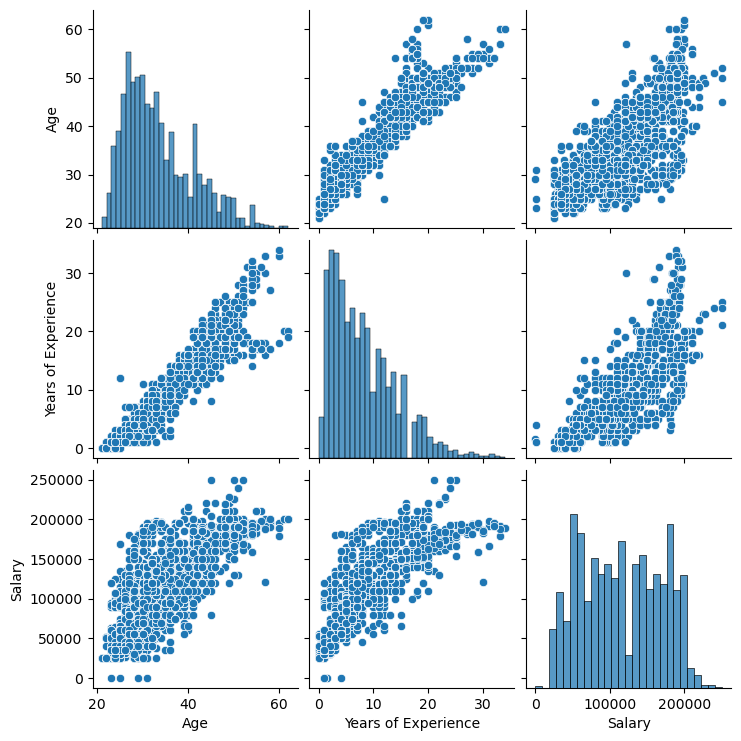

In [73]:
sns.pairplot(data=df)
plt.show()

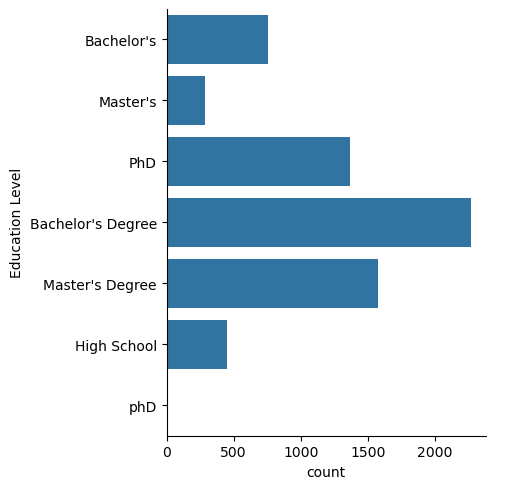

In [74]:
sns.catplot(data=df, y="Education Level", kind="count")
plt.show() 

In [75]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6702.0,33.620859,7.614633,21.0,28.0,32.0,38.0,62.0
Years of Experience,6701.0,8.094687,6.059003,0.0,3.0,7.0,12.0,34.0
Salary,6699.0,115326.964771,52786.183911,350.0,70000.0,115000.0,160000.0,250000.0


- Edad: La edad minima de las personas entrevistadas es de 21 y la edad máxima es de 62, con un promedio de 62 años.
- Años de experiencia: En la pobación encuestada se observan personas sin experencia hasta personas con experiencia de 34 años con una media de 8 años.
- Salarios: Los salarios de la población encuestada van desde 350 hasta 250000

Visualización de los datos por genero

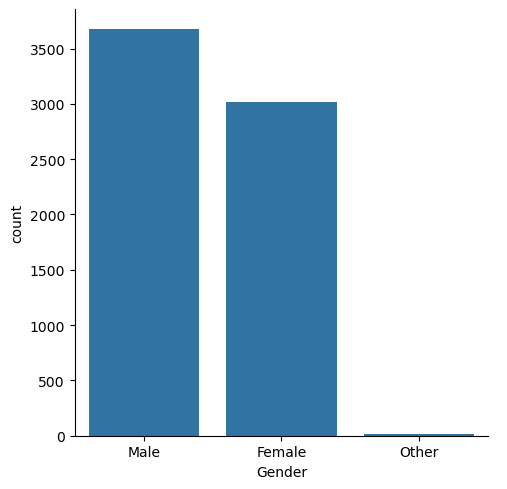

In [76]:
sns.catplot(data=df, x="Gender", kind="count")
plt.show() 

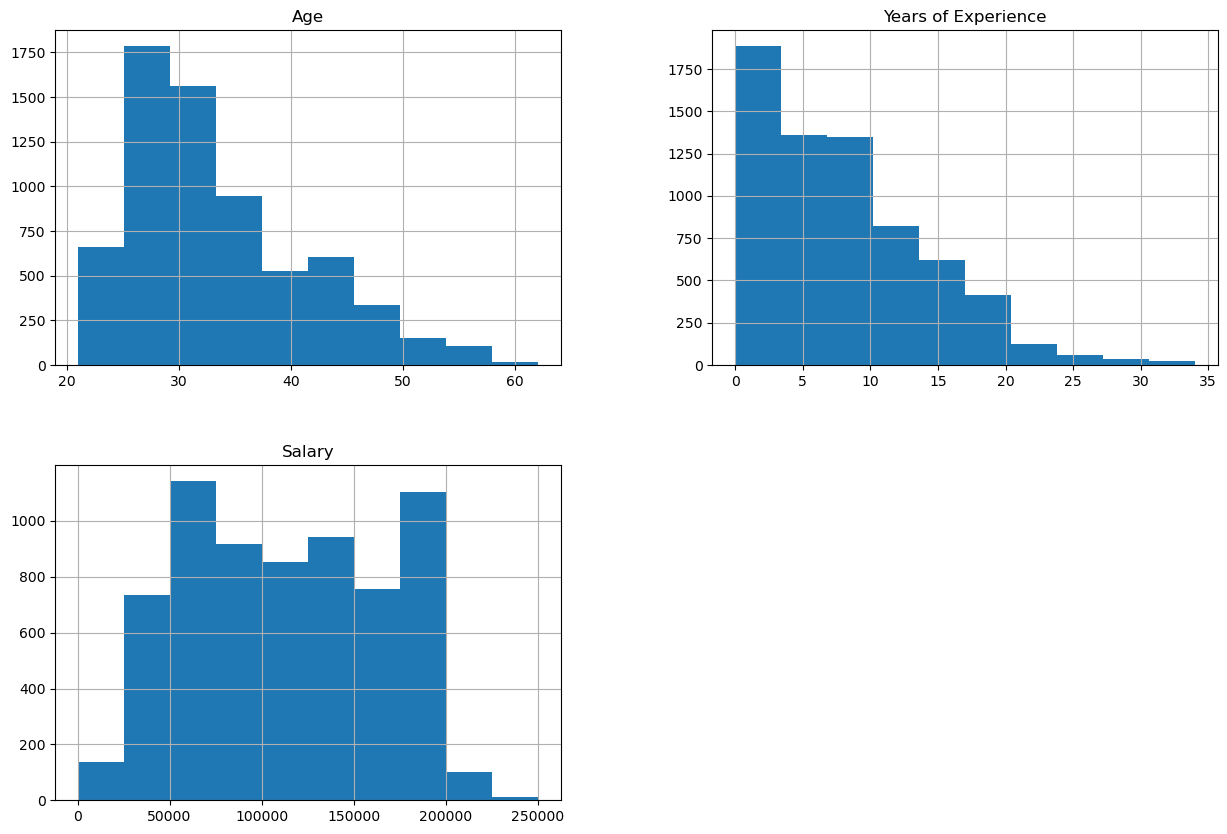

In [77]:
df.hist(figsize=(15,10))
plt.show()

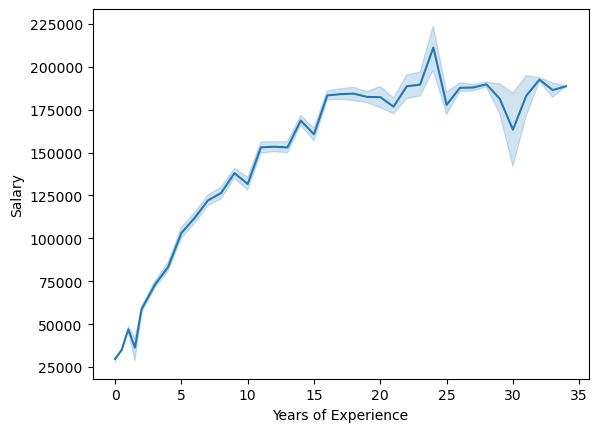

In [78]:
sns.lineplot(data = df,x = "Years of Experience",y = "Salary")
plt.show()

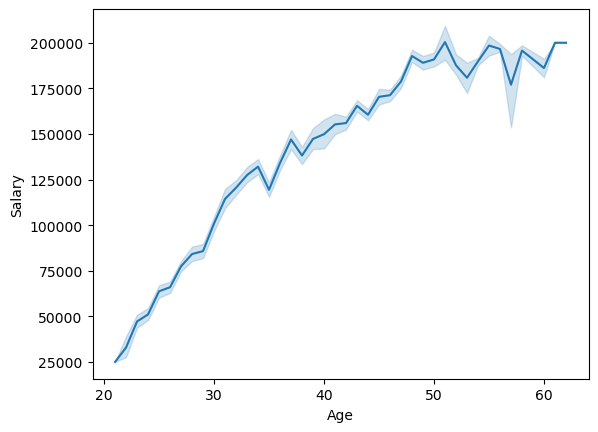

In [79]:
sns.lineplot(data = df,x = "Age",y = "Salary")
plt.show()

Se observa que la edad y los años de experiencia ayudan a describir muy bien la variable objetivo, ya que en la medida que los encuestados tienen mayor edad y por tanto mayo experiencia, nu nivel de salario también aumenta.

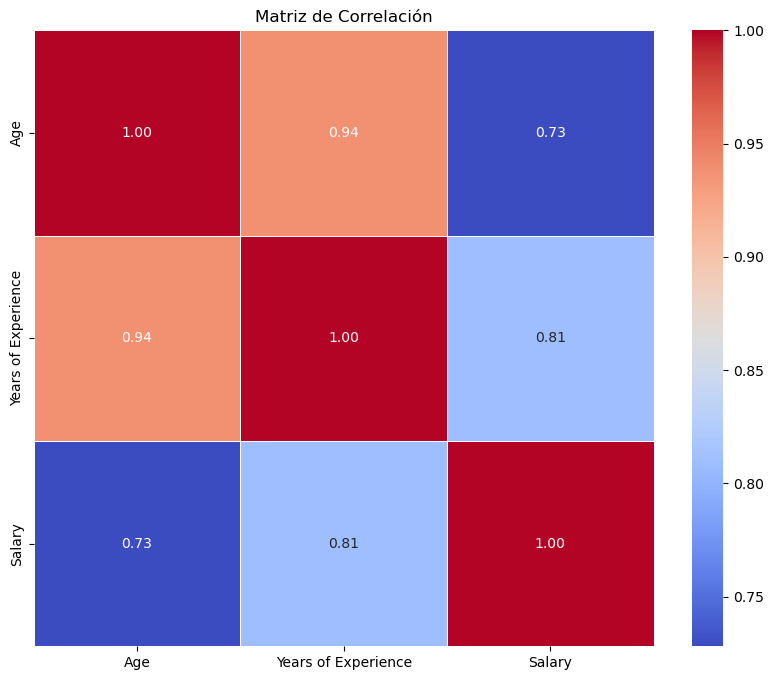

In [80]:
# Excluir columnas no numéricas
numeric_columns = df.select_dtypes(include=['float64']).columns
correlation_matrix = df[numeric_columns].corr()

# Visualizar la matriz de correlación usando un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

Se encontró que hay una correlación alta entre la edad y el salario, dado que cuanto mayor sea una persona, más ingresos obtendrá asimismo con los años de experiencia

## 3.2. Procesamiento de los datos

A continuación se realizarán las funciones que permitiran usar el conjunto de datos 'Salary_data', con el que se pretende predecir cuál será el salario de una persona, dependiendo de su nivel académico, años de experiencia, cargo al que aspira.

Creación de la clase para ajustar las variable categorica de nivel educativo

In [81]:
from sklearn.preprocessing import OneHotEncoder

class pre:
    def creation_data(self, path_csv):
        df = pd.read_csv(path_csv)
        return df
    def declaration_var(self, data, target):
        target_1 = data[target]
        features = data.drop(target, axis=1)
        names_f = {name:set() for name in features}
        for i in features:
            index_drop = features[i][features[i].isnull() == True].index
            features.drop(index_drop, inplace = True)    
            target_1.drop(index_drop, inplace = True)
        for i in features:
            for j in features[i]:
                names_f[i].add(j)   
        index_targ = target_1[target_1.isnull() == True].index
        target_1.drop(index_targ, inplace=True)   
        features.drop(index_targ, inplace=True)                    
        return target_1, features, names_f
    def replace(self, variable, var_1, var_2, features):
        new_values = [var_1 if value == var_1 or value == var_2 else value for value in features[variable]]
        features[variable] = new_values
        return features


processing = pre()

Definición del conjunto de datos del que se hará uso y la variable objetivo, junto a las demás variables

In [82]:
data = pre().creation_data('Salary_Data.csv')
target, features, names_f = pre().declaration_var(data, 'Salary')

Luego de definir el target y features, se determina que las variables "Age","Years of Experience" pueden tener un diferente tipo de formato, con el que se consuma menos recursos computacionales.

También, se encontró que en la variable Education Level, poseía errores tipográficos, donde los diferentes elementos que lo conforman estaban nombrados de diferente forma, apesar de representar el mismo objeto.

Por ejemplo, Bachelor's Degree representa una persona con un título de bachiller y Bachelor's es la forma en la que se puede resumir a una persona con el mismo título. Por lo tanto, ambos elementos comparten las mismas características y deben tomarse como objeto único.


In [83]:

# Cambia el tipo de formato
features['Age'] = features['Age'].astype('int16')
features['Years of Experience'] = features['Years of Experience'].astype('int64')

# Une las variables repetidas
features = pre().replace('Education Level', "Bachelor's", "Bachelor's Degree", features)
features = pre().replace('Education Level', "Master's", "Master's Degree", features)
features = pre().replace('Education Level', "PhD", "phD", features)

num_features = ['Age', 'Years of Experience']
cat_features = ['Gender', 'Education Level', 'Job Title']

Se define los pipelines para las variables categóricas y numéricas, además se transforma en el tipo de dato correcto (variables categóricas como OneHotEncoder y se estandariza las numéricas) para que se pueda entrenar con los diferentes modelos de regresión

## 4. Entrenamiento del Modelo 

In [84]:
def pipe(categorical_features, features):
    num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    cat_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))])
    return num_transformer, cat_transformer

def column_trans(num_transformer, num_features, cat_transformer, cat_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', num_transformer, num_features),
            ('categorical', cat_transformer, cat_features)
        ]
    )
    return preprocessor

num_transformer, cat_transformer = pipe(cat_features, features)
preprocessor = column_trans(num_transformer, num_features, cat_transformer, cat_features)

## Models

Con esta función se crean diferentes modelos de regresión como Lineal, RandomForest, Ridge

In [85]:
def gen_pipe( preprocessor):
    models = []    
    pipeline_ml = Pipeline(
        steps = [('preprocessor_column', preprocessor),
                ('linear_model', LinearRegression())])
    models.append(pipeline_ml)
        
    pipeline_ridge = Pipeline(
        steps = [('preprocessor_column', preprocessor),
                ('model_ridge', Ridge(alpha=0.2))])
    models.append(pipeline_ridge)
    pipeline_rf = Pipeline(
        steps=[('preprocessor_column', preprocessor),
            ('random_forest', RandomForestRegressor(n_estimators=200))])
    models.append(pipeline_rf)
    
    # params = [{'ridge__alpha': np.logspace(-3, 5, num=30)}]
    # pipeline_gridsearch = clf = GridSearchCV(pipeline_ridge, param_grid=params, scoring="r2", cv=20) 
    # models.append(pipeline_gridsearch)
    return models

División de los datos de entrenamiento y de prueba

In [86]:
X_train, X_test,y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
models = gen_pipe(preprocessor)
models_metrics = {i:[] for i in range(len(models)) }
for i in models_metrics:
    n_bootstraps = 1000
    model = models[i].fit(X_train, y_train)
    prediction = model.predict(X_test)
    bootstraps_predict = []
    for _ in range(n_bootstraps):
        muestras_bootstrap = resample(prediction)
        statics_bootstrap = np.mean(muestras_bootstrap)
        bootstraps_predict.append(statics_bootstrap)
    int_conf = np.percentile(bootstraps_predict, [5, 95])
    for j in range(len(int_conf)):
        int_conf[j] = round(int_conf[j], 2)
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    list_1 = [r2,mse,rmse, int_conf]
    models_metrics[i] = [metrics for metrics in list_1]

In [87]:
names = ['LinearRegression', 'Ridge', 'RandomForestRegressor', ]
index_final = ['R2', 'mse', 'rmse', 'intervalo de confianza']

models_metrics = pd.DataFrame(data = models_metrics,index = index_final)
models_metrics.columns = names
models_metrics

,LinearRegression,Ridge,RandomForestRegressor
R2,0.840184,0.840205,0.974884
mse,455709421.883616,455648120.237456,71618622.738778
rmse,21347.351636,21345.915774,8462.778665
intervalo de confianza,"[112835.58, 117127.56]","[112833.12, 117233.64]","[112490.6, 117294.86]"


## Interpretación 


### Regresión Lineal y Ridge:

* Ambos modelos (Regresión Lineal y Ridge) tienen un rendimiento bastante similar con valores de R^2 alrededor de 455, y MSE y RMSE similares.
* El mejor parámetro de ajuste y los valores de R^2 son altos, indicando que el modelo explica bien la variabilidad en los datos.


### Random Forest 

* El modelo de Bosques Aleatorios tiene un rendimiento superior en términos de R^2, mostrando una capacidad significativamente mejor para explicar la variabilidad en los datos.
* El MSE y RMSE son más bajos en comparación con los modelos lineales, indicando que el modelo de Bosques Aleatorios tiene una mejor capacidad predictiva.

El modelo random forest el más efectivo entre los tres, al menos según las métricas proporcionadas.

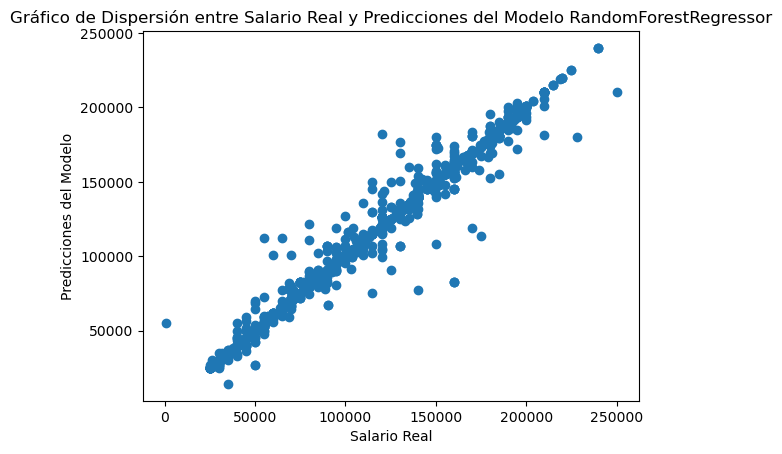

In [88]:
plt.scatter(y_test, prediction)
plt.xlabel('Salario Real')
plt.ylabel('Predicciones del Modelo')
plt.title('Gráfico de Dispersión entre Salario Real y Predicciones del Modelo RandomForestRegressor')
plt.show()

### Creamos dos modelos RandomizedSearchCV y GridSearchCV

In [89]:
pipeline = make_pipeline(  preprocessor,   Ridge() ) 

# Definir GridSearchC con r2 como scoring  usando 20-folds
params = [{'ridge__alpha': np.logspace(-3, 5, num=30)}]
clf = GridSearchCV(pipeline, param_grid=params, scoring="r2", cv=20) 
clf.fit(X_train, y_train) 



GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('ridge', Ridge())]),
             param_gri...
       1.26896100e-02, 2.39502662e-02, 4.52035366e-02, 8.53167852e-02,
       1.61026203e-01, 3.03919538e-01, 5.73615251e-01, 1.08263673e+00,
       2.04335972e+00, 3.85662042e+00, 7.27895384e+00, 1.37382380e+01,
       2.59294380e+01, 4.89390092e+01, 9.23670857e+01, 1.74332882e+02,
       3.29034456e+02, 6.21016942e+02, 1.17210230e+03, 2.21221629e+03,
       4.17531894e+03, 7.88046282e+03, 1.48735211e+04, 2.80721620e+04,
       5.29831691e+04, 1.00000000e+05])}],
             scoring='r2')

In [90]:
pipeline1 = make_pipeline( preprocessor,   Ridge() ) 
params = [{'ridge__alpha': np.logspace(-3, 5, num=30)}]
clf1 = RandomizedSearchCV(pipeline1, param_distributions=params, n_iter=300, cv=5, scoring="r2")
clf1.fit(X_train, y_train) 

c:\Users\santi\.conda\envs\mi_entorno\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 30 is smaller than n_iter=300. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Years '
                                                                                'of '
                                                                                'Experience']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('one_hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Education '
                                                                                'Level',
                                                                                'Job '
                                                                                'Title'])])),
                                             ('ridge', Ridge())]),
                   n_it...
       1.26896100e-02, 2.39502662e-02, 4.52035366e-02, 8.53167852e-02,
       1.61026203e-01, 3.03919538e-01, 5.73615251e-01, 1.08263673e+00,
       2.04335972e+00, 3.85662042e+00, 7.27895384e+00, 1.37382380e+01,
       2.59294380e+01, 4.89390092e+01, 9.23670857e+01, 1.74332882e+02,
       3.29034456e+02, 6.21016942e+02, 1.17210230e+03, 2.21221629e+03,
       4.17531894e+03, 7.88046282e+03, 1.48735211e+04, 2.80721620e+04,
       5.29831691e+04, 1.00000000e+05])}],
                   scoring='r2')

In [91]:
data = {
    "Modelo": ["clf", "clf1"],
    "Mejor parámetro de ajuste": [clf.best_params_, clf1.best_params_],
    "Mejor R2 obtenido": [clf.best_score_, clf1.best_score_],
    "Score en el conjunto de prueba": [clf.score(X_test, y_test), clf1.score(X_test, y_test)]
}

# Crear el DataFrame
df = pd.DataFrame(data)

df

,Modelo,Mejor parámetro de ajuste,Mejor R2 obtenido,Score en el conjunto de prueba
0,clf,{'ridge__alpha': 0.3039195382313198},0.833696,0.840203
1,clf1,{'ridge__alpha': 0.3039195382313198},0.834468,0.840203


## Interpretación

* Mejor parámetro de ajuste: {'ridge__alpha': 0.3039195382313198}

Este valor representa el mejor valor encontrado para el hiperparámetro alpha del modelo Ridge durante la búsqueda aleatoria. El alpha controla la fuerza de regularización en Ridge, y un valor más bajo indica menos regularización.

* Mejor R^2 obtenido: 

0.8336976388148226
El coeficiente de determinación (R^2) es una medida de qué tan bien el modelo se ajusta a los datos. Un valor de 1 indica un ajuste perfecto, y 0 indica que el modelo no explica la variabilidad en los datos. En este caso, un R^2 de 0.83 sugiere que el modelo Ridge explica el 83% de la variabilidad en los datos de entrenamiento.
Score en el conjunto de prueba:

0.8401856080511727
Esta es la puntuación R^2 en el conjunto de prueba. Indica qué tan bien el modelo generaliza a datos no vistos. Un R^2 cercano a 1 en el conjunto de prueba sugiere que el modelo generaliza bien.
Interpretación general:
El mejor valor de alpha encontrado sugiere que un nivel moderado de regularización (ni demasiado fuerte ni demasiado débil) es óptimo para el modelo Ridge en este caso.

El R^2 obtenido en el conjunto de entrenamiento es bastante alto (0.83), lo que indica un buen ajuste del modelo a los datos de entrenamiento.

La puntuación R^2 en el conjunto de prueba (0.84) sugiere que el modelo Ridge generaliza bien a datos no vistos, lo cual es positivo.


## 5. Ajuste de hiperparametros

In [92]:
def gen_pipe(preprocessor):
    models = []
    
    # Modelo de regresión lineal
    pipeline_ml = Pipeline(
        steps=[('preprocessor_column', preprocessor),
               ('linear_model', LinearRegression())])
    models.append(pipeline_ml)
    
    # Modelo de Ridge
    pipeline_ridge = Pipeline(
        steps=[('preprocessor_column', preprocessor),
               ('model_ridge', Ridge(alpha=0.2))])
    models.append(pipeline_ridge)
    
    # Modelo de Random Forest con búsqueda de hiperparámetros
    param_grid_rf = {
        'random_forest__n_estimators': [100, 200, 300],
        'random_forest__max_depth': [None, 10, 20],
        'random_forest__min_samples_split': [2, 5, 10],
        'random_forest__min_samples_leaf': [1, 2, 4]
    }
    
    pipeline_rf = Pipeline(
        steps=[('preprocessor_column', preprocessor),
               ('random_forest', RandomForestRegressor())])
    
    grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    models.append(grid_search_rf)
    
    return models
models_metrics = {i:[] for i in range(len(models)) }
for i in models_metrics:
    n_bootstraps = 1000
    model = models[i].fit(X_train, y_train)
    prediction = model.predict(X_test)
    bootstraps_predict = []
    for _ in range(n_bootstraps):
        muestras_bootstrap = resample(prediction)
        statics_bootstrap = np.mean(muestras_bootstrap)
        bootstraps_predict.append(statics_bootstrap)
    int_conf = np.percentile(bootstraps_predict, [5, 95])
    for j in range(len(int_conf)):
        int_conf[j] = round(int_conf[j], 2)
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    list_1 = [r2,mse,rmse, int_conf]
    models_metrics[i] = [metrics for metrics in list_1]
    
names = ['LinearRegression', 'Ridge', 'RandomForestRegressor', ]
index_final = ['R2', 'mse', 'rmse', 'intervalo de confianza']

models_metrics = pd.DataFrame(data = models_metrics,index = index_final)
models_metrics.columns = names
models_metrics

,LinearRegression,Ridge,RandomForestRegressor
R2,0.840184,0.840205,0.974891
mse,455709421.883616,455648120.237456,71596470.387876
rmse,21347.351636,21345.915774,8461.469753
intervalo de confianza,"[112675.95, 117178.61]","[112953.22, 117371.49]","[112400.46, 117218.83]"


In [93]:
r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)
data = {
    "Métrica": ["Mejor R2 obtenido", "MSE", "RMSE"],
    "Valor": [r2, mse, rmse]
}
df = pd.DataFrame(data)
print('El modelo con mejores métricas es RandomForest')
df


El modelo con mejores métricas es RandomForest


,Métrica,Valor
0,Mejor R2 obtenido,9.748913e-01
1,MSE,7.159647e+07
2,RMSE,8.461470e+03


## Interpretación 

* Mejor R^2 obtenido:

0.9746690877213477
Un R^2 de 0.97 indica un ajuste extremadamente fuerte del modelo a los datos de prueba. El 97% de la variabilidad en la variable objetivo (salario, en este caso) se explica por el modelo. Es un resultado muy positivo.

* MSE (Error Cuadrático Medio):

72230064.09132643
El MSE es la media de los cuadrados de los errores entre las predicciones y los valores reales. 

* RMSE (Raíz del Error Cuadrático Medio):

8498.827218582952
El RMSE es la raíz cuadrada del MSE y proporciona una medida de la magnitud promedio de los errores en la misma unidad que la variable objetivo. Un RMSE bajo indica que el modelo tiene un buen ajuste y las predicciones son precisas.

## 6. Conclusiones

Se inició el proceso  con modelos de regresión lineal simple, Ridge con un alpha fijo, y un modelo de random forest con hiperparámetros arbitrarios.

En la medida que se ajustaton los hiperparametros los modelos mostraron mejora en las metricas 

* El modelo Ridge mejoró su rendimiento después de RandomizedSearchCV, mostrando un R^2 más alto y un mejor score en el conjunto de prueba.

* El modelo de Bosques Aleatorios, después de la GridSearchCV, alcanzó un rendimiento excepcional con un R^2 de 0.97 y un bajo RMSE en el conjunto de prueba.